# Lec3 Quantum Machine Learning
Reference
- [[Youtube]【誰でも量子コンピュータ！量子機械学習編】Quantum Computing for You【第3回・9/22実施】](https://www.youtube.com/watch?v=L4TSZBOlq-k&list=TLGGDOGXcmiqXZowNDA1MjAyNA)

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit_aer import Aer
from qiskit.visualization import array_to_latex

In [2]:
import numpy as np
from sympy.physics.quantum.qubit import matrix_to_qubit

In [3]:
def sim_state(qc, disp=True):
    sim = Aer.get_backend('statevector_simulator')
    qc = transpile(qc, backend=sim)
    res = sim.run(qc).result()
    state = res.data()['statevector']
    if disp:
        ket = matrix_to_qubit(np.array(state)[:, np.newaxis])
        print(ket)
    return state

In [4]:
n = 2
qc = QuantumCircuit()
qr = QuantumRegister(n)
qc.add_register(qr)
qc.h(qr)

In [5]:
state = sim_state(qc)

0.5*|00> + 0.5*|01> + 0.5*|10> + 0.5*|11>


---
### $CX \cdot Z  \cdot CX$について

In [6]:
n = 2
qc = QuantumCircuit()
qr = QuantumRegister(n)
qc.add_register(qr)

In [7]:
qc.h(qr)
qc.cx(qr[0], qr[1])
qc.z(qr[1])
qc.cx(qr[0], qr[1])

In [8]:
qc.draw()

┌───┐               
q3_0: ┤ H ├──■─────────■──
      ├───┤┌─┴─┐┌───┐┌─┴─┐
q3_1: ┤ H ├┤ X ├┤ Z ├┤ X ├
      └───┘└───┘└───┘└───┘

In [9]:
state = sim_state(qc)

0.5*|00> - 0.5*|01> - 0.5*|10> + 0.5*|11>


上記の結果の説明について、
$$
\begin{align}
    \ket{00} \xrightarrow{CX} \ket{00} &\xrightarrow{2bit目にZ} &\ket{00} \xrightarrow{CX} &\ket{00} \\
    \ket{01} \xrightarrow{CX} \ket{11} &\xrightarrow{2bit目にZ} &-\ket{11} \xrightarrow{CX} &-\ket{01} \\
    \ket{10} \xrightarrow{CX} \ket{10} &\xrightarrow{2bit目にZ} &-\ket{10} \xrightarrow{CX} &-\ket{10} \\
    \ket{11} \xrightarrow{CX} \ket{01} &\xrightarrow{2bit目にZ} &\ket{01} \xrightarrow{CX} &\ket{11} \\
\end{align}
$$
となる。よって最終的に、$\ket{\psi} = \frac{1}{2}\ket{00} - \frac{1}{2}\ket{01} - \frac{1}{2}\ket{10} + \frac{1}{2}\ket{11}$となる。

---
### 回転について

In [10]:
n = 2
qc = QuantumCircuit()
qr = QuantumRegister(n)
qc.add_register(qr)

In [11]:
qc.h(qr)

theta = 0.5
qc.cx(qr[0], qr[1])
qc.rz(theta, qr[1]) # z軸周りに角度theta回す
qc.cx(qr[0], qr[1])

In [12]:
qc.draw()

┌───┐                     
q7_0: ┤ H ├──■───────────────■──
      ├───┤┌─┴─┐┌─────────┐┌─┴─┐
q7_1: ┤ H ├┤ X ├┤ Rz(0.5) ├┤ X ├
      └───┘└───┘└─────────┘└───┘

In [13]:
state = sim_state(qc)

0.484456210855322*|00> - 0.123701979627261*I*|00> + 0.484456210855322*|01> + 0.123701979627261*I*|01> + 0.484456210855322*|10> + 0.123701979627261*I*|10> + 0.484456210855322*|11> - 0.123701979627261*I*|11>


In [14]:
from qiskit.quantum_info.operators import Operator, Pauli

In [15]:
# 期待値の計算　（一度、手でも計算してみたい）
op = Operator(Pauli('ZI')) + Operator(Pauli('IZ'))
y = state.expectation_value(op)
print(y)

(4.718447854656915e-16+0j)



$Z$ゲートを表す行列は
$$
Z = 
\begin{pmatrix}
   1 & 0 \\
   0 & -1
\end{pmatrix}
, I = 
\begin{pmatrix}
   1 & 0 \\
   0 & 1
\end{pmatrix}
$$

$Z \otimes I + I \otimes Z = $  
また、物理的な意味について。

---
### Ising Model

In [16]:
n = 2
qc = QuantumCircuit()
qr = QuantumRegister(n)
qc.add_register(qr)

In [17]:


theta_z = 0.3
theta_x = 0.5

qc.cx(qr[0], qr[1])
qc.rz(theta_z, qr[1]) # z軸周りに角度theta回す
qc.cx(qr[0], qr[1])

# 横磁場をかける。
qc.rx(theta_x, qr)

In [18]:
def Ising_dynamics(n, theta_z, theta_x):
    qc = QuantumCircuit()
    qr = QuantumRegister(n)
    qc.add_register(qr)

    # 横磁場をかける。
    for k in range(n):
        qc.rx(theta_x[k], qr[k])
    # Ising模型の相互作用
    if n > 1:
        for k in range(n-1):
            qc.cx(qr[k], qr[k+1])
            qc.rz(theta_z[k+1], qr[k+1])
            qc.cx(qr[k], qr[k+1])
        qc.cx(qr[n-1], qr[0])
        qc.rz(theta_z[0], qr[0])
        qc.cx(qr[n-1], qr[0])

    UIsing = qc.to_gate()
    UIsing.name = 'UIsing'

    return UIsing

In [19]:
def mag_exp(qc, n):
    '''
    期待値を計算する。
    '''
    state = sim_state(qc, disp=False)
    op = Operator(np.zeros([2**n, 2**n]))
    for k in range(n):
        op_str = ''
        for l in range(n):
            if l == k:
                op_str += 'Z'
            else:
                op_str += 'I'
        op += Operator(Pauli(op_str))
        
    y = state.expectation_value(op)/n
    return y

In [20]:
# Ising modelの量子シミュレーション

n = 5
Tall = 50
m_series = []

dt = 0.1

qc = QuantumCircuit()
qr = QuantumRegister(n)
qc.add_register(qr)

theta_x = 5.0*np.ones(n)*dt
theta_z = 3.0*np.ones(n)*dt

UIsing = Ising_dynamics(n, theta_z, theta_x)

In [21]:
for t in range(Tall):
    qc.append(UIsing, qr)
    m = mag_exp(qc, n)
    m_series.append(m)

/home/user/anaconda3/envs/quantum/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/user/anaconda3/envs/quantum/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


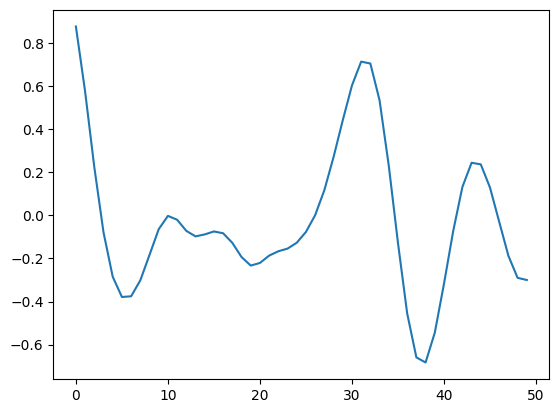

In [22]:
import matplotlib.pyplot as plt
plt.plot(m_series)

---
### 量子機械学習

In [23]:
def U_in(x, n):
    '''
    Args:
        x データ。-1〜1に規格化された
    '''
    qc = QuantumCircuit()
    qr = QuantumRegister(n)
    qc.add_register(qr)

    angle = np.arcsin(x)
    qc.rx(angle, qr)
    
    U_in = qc.to_gate()
    U_in.name = 'U_in'

    return U_in

In [24]:
def QCLinput(x, n):
    '''
    量子回路を作るための関数
    '''
    qc = QuantumCircuit()
    qr = QuantumRegister(n)
    qc.add_register(qr)
    qc.append(U_in(x, n), qr)
    return qc

In [25]:
n = 3
x = 0.1

qc = QCLinput(x, n)
y = mag_exp(qc, n)
print(y)

(0.9949874371066201+0j)


In [26]:
qc.draw()

┌───────┐
q164_0: ┤0      ├
        │       │
q164_1: ┤1 U_in ├
        │       │
q164_2: ┤2      ├
        └───────┘

In [27]:
x_series = np.linspace(-1, 1, 100)
y_series = []

for x in x_series:
    qc = QCLinput(x, n)
    y = mag_exp(qc, n)
    y_series.append(y)

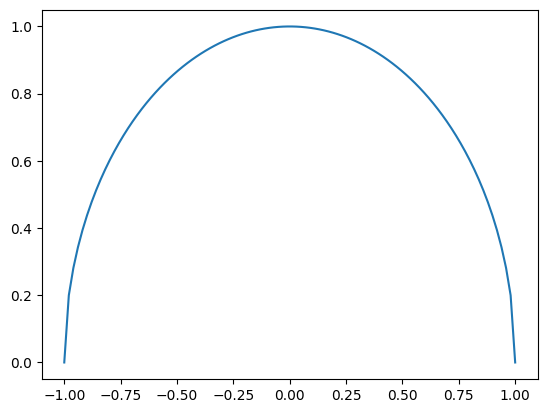

In [28]:
plt.plot(x_series, y_series)
plt.show()

In [29]:
def U_rot(n, params):
    '''
    Args:
        n (int):
        params (list): rx: 0, 1, 2, ..., n-1
                       ry: n, n+1, n+2, ..., n+n-1
                       rz: 2n, 2n+1, 2n+2, ..., 2n+n-1
    '''
    qc = QuantumCircuit()
    qr = QuantumRegister(n)
    qc.add_register(qr)
    for k in range(n):
        qc.rx(params[k], qr[k])
        qc.ry(params[n+k], qr[k])
        qc.rz(params[2*n+k], qr[k])
    Urot = qc.to_gate()
    Urot.name = 'Urot'
    return Urot

In [30]:
y_series = []
params = np.random.rand(3*n)*2*np.pi

for x in x_series:
    # 入力層
    qc = QCLinput(x, n)
    qr = qc.qubits
    # 中間層
    qc.append(U_rot(n, params), qr)
    # 出力層
    y = mag_exp(qc, n)
    y_series.append(y)

In [31]:
qc.draw()

┌───────┐┌───────┐
q1061_0: ┤0      ├┤0      ├
         │       ││       │
q1061_1: ┤1 U_in ├┤1 Urot ├
         │       ││       │
q1061_2: ┤2      ├┤2      ├
         └───────┘└───────┘

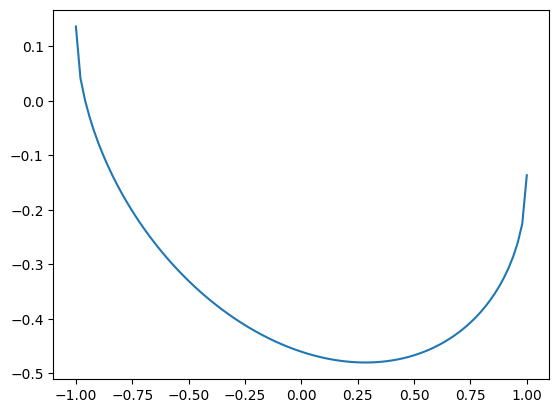

In [32]:
plt.plot(x_series, y_series)
plt.show()

In [33]:
def U_ent(n):
    '''
    entanglement
    '''
    qc = QuantumCircuit()
    qr = QuantumRegister(n)
    qc.add_register(qr)

    if n > 1:
        for k in range(n-1):
            qc.cz(qr[k], qr[k+1])
        qc.cz(qr[n-1], qr[0])

    Uent = qc.to_gate()
    Uent.name = 'U_ent'

    return Uent    

In [34]:
y_series = []
depth = 3
params = np.random.rand(3*n*depth)*2*np.pi

for x in x_series:
    # 入力層
    qc = QCLinput(x, n)
    qr = qc.qubits
    # 中間層
    for k in range(depth):
        qc.append(U_ent(n), qr)
        qc.append(U_rot(n, params[k*3*n:(k+1)*3*n]), qr)
    # 出力層
    y = mag_exp(qc, n)
    y_series.append(y)

In [35]:
qc.draw()

┌───────┐┌────────┐┌───────┐┌────────┐┌───────┐┌────────┐┌───────┐
q2255_0: ┤0      ├┤0       ├┤0      ├┤0       ├┤0      ├┤0       ├┤0      ├
         │       ││        ││       ││        ││       ││        ││       │
q2255_1: ┤1 U_in ├┤1 U_ent ├┤1 Urot ├┤1 U_ent ├┤1 Urot ├┤1 U_ent ├┤1 Urot ├
         │       ││        ││       ││        ││       ││        ││       │
q2255_2: ┤2      ├┤2       ├┤2      ├┤2       ├┤2      ├┤2       ├┤2      ├
         └───────┘└────────┘└───────┘└────────┘└───────┘└────────┘└───────┘

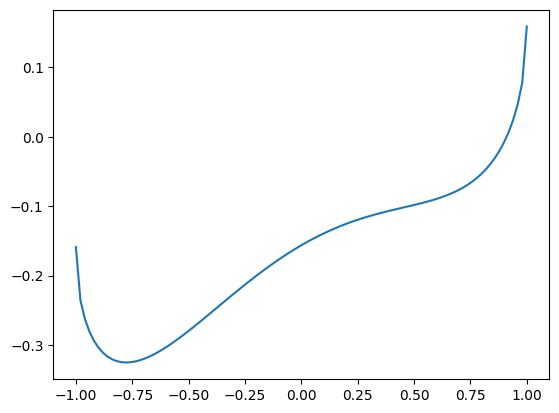

In [36]:
plt.plot(x_series, y_series)
plt.show()

#### 学習

In [37]:
# 真値
func = lambda x: 0.5*x**3

In [38]:
ntrain = 10

# 訓練データ（-1〜1）
xtrain = 2*np.random.rand(ntrain)-1
# 教師データ
ytrain = func(xtrain)

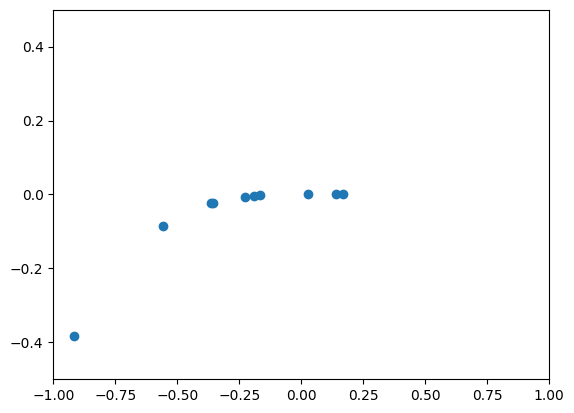

In [39]:
plt.scatter(xtrain, ytrain)
plt.xlim([-1, 1])
plt.ylim([-0.5, 0.5])
plt.show()

In [40]:
def cost_func(params):
    '''
    コスト関数
    '''
    cost_total = 0
    for k in range(ntrain):
        x = xtrain[k]
        qc = QCLinput(x, n)
        qr = qc.qubits
        for d in range(depth):
            qc.append(U_ent(n), qr)
            qc.append(U_rot(n, params[d*3*n:(d+1)*3*n]), qr)
        y = mag_exp(qc, n)
        cost = 0.5*(ytrain[k]-y)**2
        cost_total += cost
    cost_total /= ntrain
    return cost_total

In [41]:
from scipy.optimize import minimize

# 勾配を使わない、探索的な最適化方法
result =  minimize(cost_func, params, method='COBYLA', options={'maxiter': 50})

/home/user/anaconda3/envs/quantum/lib/python3.9/site-packages/scipy/optimize/_cobyla_py.py:293: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,


In [42]:
# 0に近いほうが良い。
result.fun

0.0006175679921497584

In [43]:
result.x

array([2.0833258 , 3.92104331, 4.39718552, 1.76831441, 4.40360522,
       4.64364933, 1.41496936, 2.66162753, 4.46048825, 5.43884493,
       1.17650609, 0.0794803 , 2.58360064, 6.26139032, 0.92113448,
       5.9165779 , 3.79691425, 3.6880197 , 2.48654529, 1.31895073,
       7.25368408, 4.60155874, 3.97665176, 3.55139356, 4.31669774,
       2.84165533, 4.91029984])

In [44]:
# 学習済みのパラメータを使って推論
y_series = []
params = result.x

for x in x_series:
    qc = QCLinput(x, n)
    qr = qc.qubits
    for d in range(depth):
        qc.append(U_ent(n), qr)
        qc.append(U_rot(n, params[d*3*n:(d+1)*3*n]), qr)
    y = mag_exp(qc, n)
    y_series.append(y)

In [45]:
y_correct = func(x_series)

/home/user/anaconda3/envs/quantum/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/user/anaconda3/envs/quantum/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


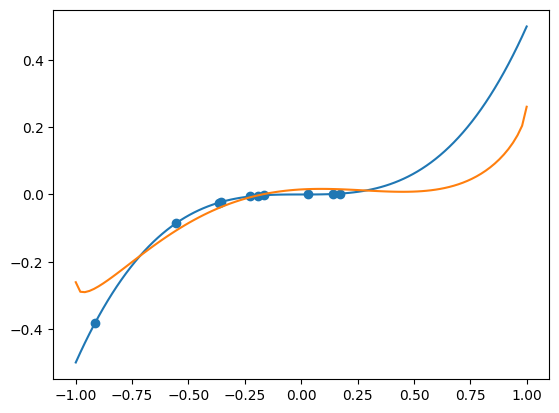

In [46]:
plt.scatter(xtrain, ytrain)
plt.plot(x_series, y_correct)
plt.plot(x_series, y_series)
plt.show()